# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Import Libraries and read data files

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier 


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Understanding

### portfolio

In [2]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [4]:
portfolio['id'].count()

10

In [5]:
portfolio.shape

(10, 6)

We can see that there are 10 offers.
Now lets look at the distribution of the offer_type

In [6]:
def plot_hbar_chart(df,col_Name,plt_name,x_label,y_label):
    '''
    INPUTS:
    df: the dataframe
    col_name: the name of column to display the bar chart
    plt_name: Name of the plot
    x_label: the x_label for the chart
    Y-label: the y_label for the chart
    
    OUTPUT:
    Bar Chart
    '''
    x_values=df[col_Name].unique() # values on x axis
    y_values=df[col_Name].value_counts() #values on y axis
    fig, ax = plt.subplots()    
    width = 0.5 #width of the bars
    ind = np.arange(len(y_values))  # the x locations for the groups
    ax.barh(ind, y_values, width, color=["red","blue","green","yellow","black","purple"])
    ax.set_yticks(ind+width/2)
    ax.set_yticklabels(x_values, minor=False)
    for i, v in enumerate(y_values):
        ax.text(v , i , str(v), color='black', fontweight='bold')
    plt.title(plt_name)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

Lets look at the distribution of offer_type

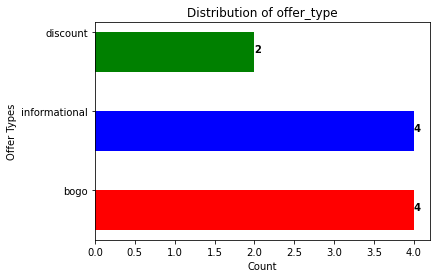

In [7]:
plot_hbar_chart(portfolio,'offer_type',"Distribution of offer_type","Count","Offer Types")

Now, lets look at the distribution of 'reward'

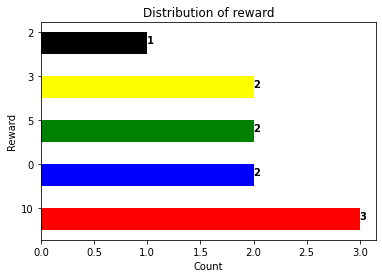

In [8]:
plot_hbar_chart(portfolio,'reward',"Distribution of reward","Count","Reward")

## Data Cleansing

### portfolio

In [9]:
def clean_channels (df):
    '''
    INPUT: portfolio dataframe
    
    OUTPUT: Cleaned portfolio dataframe with clean channel info
    '''
    channels=df.channels.apply(pd.Series).stack() #convert each value in channels to a series
    channels=pd.get_dummies(channels).groupby(level=0).sum() #get a dataframe with 1s and 0s for channels
    df=pd.concat([df, channels], axis=1) #concatenate the channels column and the original dataframe
    df=df.drop(columns=['channels'])
    
    return df

In [10]:
portfolio_clean=clean_channels(portfolio)

In [11]:
portfolio_clean.head()

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


Rename 'id' to 'offer_id'

In [12]:
portfolio_clean=portfolio_clean.rename(columns={"id": "offer_id"})

## Data Understanding

### profile

In [13]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [14]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [15]:
profile.shape

(17000, 5)

FInd the % of missing values

In [16]:
profile.isnull().mean()

gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

<AxesSubplot:>

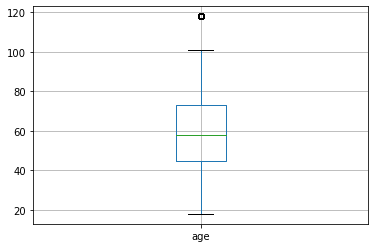

In [17]:
profile.boxplot(column=['age'])

## Data Cleansing

### profile

'gender' and 'income' columns have around 12.8% missing values. As these columns are important demographic information and they make up 50% of the demographic data, the rows with missing values can be dropped

In [18]:
profile_clean=profile.copy()

In [19]:
profile_clean=profile_clean.dropna(axis=0, how='any')

In [20]:
profile_clean.shape

(14825, 5)

In [21]:
profile_clean.isnull().mean()

gender              0.0
age                 0.0
id                  0.0
became_member_on    0.0
income              0.0
dtype: float64

<AxesSubplot:>

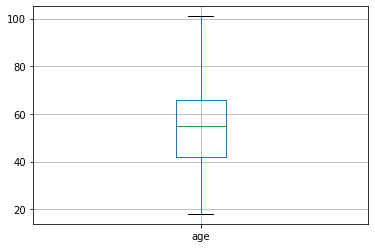

In [22]:
profile_clean.boxplot(column=['age'])

In [23]:
profile_clean['gender'].unique()

array(['F', 'M', 'O'], dtype=object)

Distribution of Gender

In [24]:
def plt_pie_chart (df,col_name,plt_name):
    '''
    This is a function to plot a pie chart.
    INPUTS:
    df: the dataframe
    col_name: the name of the column
    plt_name: the name of the pie chart
    
    OUTPUT: a pie chart
    '''
    categories=['Male','Female','Other'] # unique values
    counts=df[col_name].value_counts() #count of the values in the categories
    colors = ( "orange","purple", "yellow")
    explode = (0.1, 0, 0)
    fig1, ax1 = plt.subplots()
    ax1.pie(counts,  labels=categories,explode=explode, autopct='%1.1f%%',shadow=True, startangle=90)
    ax1.axis('equal') 
    plt.title(plt_name)
    plt.show()

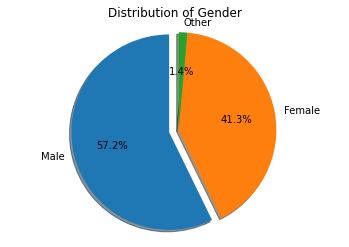

In [25]:
plt_pie_chart(profile_clean,'gender','Distribution of Gender')

Change the date format

Assumption: The current date is assumed to be '2018-09-01'. This is done because if the current date is assumed to be now (2021-02-06) then the days_since_membership calculated below would not be relevant as there is large time gap between when the data is available and now.

In [26]:
def clean_member_date (df):
    '''
    INPUT: the profile dataframe
    
    OUTPUT: dataframe with cleaned member date
    '''
    ##change the format of became_member_on column to datetime
    df['became_member_on']=pd.to_datetime(df['became_member_on'], format='%Y%m%d')
    
    ##get the days_since_member from the became_member_on column. See assumption above.
    df['days_since_member']=pd.to_datetime('2018-09-01')-df['became_member_on']
    
    ##drop became_member_on column
    df=df.drop(columns=['became_member_on'])
    
    ##rename id to person_id
    df=df.rename(columns={"id": "person_id"})
    
    ##convert days_since_member to number of days
    days=df["days_since_member"].dt.days
    
    ##rename to days_since_membership
    days=days.rename("days_since_membership")
    
    ##concat the 2 data frames
    df=pd.concat([df, days], axis=1)
    
    ##drop days_since_member column
    df=df.drop(columns=['days_since_member'])
    
    return df

In [27]:
profile_clean=clean_member_date(profile_clean)

In [28]:
profile_clean.head()

,gender,age,person_id,income,days_since_membership
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,413
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,480
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,128
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,204
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,294


In [29]:
profile_clean.describe()

,age,income,days_since_membership
count,14825.000000,14825.000000,14825.000000
mean,54.393524,65404.991568,559.478988
std,17.383705,21598.299410,419.205158
min,18.000000,30000.000000,37.000000
25%,42.000000,49000.000000,245.000000
50%,55.000000,64000.000000,395.000000
75%,66.000000,80000.000000,834.000000
max,101.000000,120000.000000,1860.000000


## Data Understanding

### transcript

In [30]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [31]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [32]:
transcript.event.unique() 

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

Lets look at the distribution of the values in 'event' column

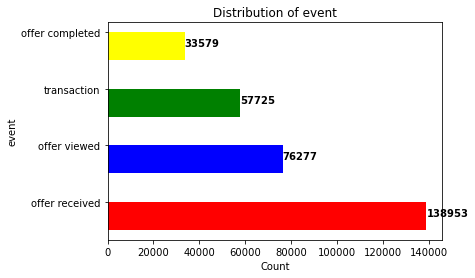

In [33]:
plot_hbar_chart(transcript,'event',"Distribution of event","Count","event")

The above chart gives the total number of records for the different event type. But if we want to know the unique number of customers who are associated with the different event types, we can get the numbers from below:

In [34]:
transcript.groupby('event').person.nunique()

event
offer completed    12774
offer received     16994
offer viewed       16834
transaction        16578
Name: person, dtype: int64

In [35]:
transcript.isnull().mean()

person    0.0
event     0.0
value     0.0
time      0.0
dtype: float64

## Data Cleansing

### transcript

In [36]:
def clean_value_col (df):
    '''
    INPUT: the transcript dataframe
    
    OUTPUT: cleaned dataframe with clean value column
    
    This function takes the transcript dataframe as input and returns cleaned transcript dataframe
    '''
    df1=df['value'].apply(pd.Series) # create new dataframe
    df2=pd.concat([df,df1],axis=1) # concatenate 2 dataframes
    df2['clean_offer_id']=df2['offer_id'].fillna(df2['offer id']) #create one column for holding the offer_id
    df2=df2.drop(columns=['offer id','offer_id','value']) # drop columns
    df2=df2.rename(columns={"clean_offer_id": "offer_id"}) #rename column
    return df2

In [37]:
transcript_clean=clean_value_col(transcript)

In [38]:
transcript_clean.isnull().sum()

person           0
event            0
time             0
amount      167581
reward      272955
offer_id    138953
dtype: int64

In [39]:
transcript_clean.head()

,person,event,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [40]:
transcript_clean.describe()

,time,amount,reward
count,306534.000000,138953.000000,33579.000000
mean,366.382940,12.777356,4.904137
std,200.326314,30.250529,2.886647
min,0.000000,0.050000,2.000000
25%,186.000000,2.780000,2.000000
50%,408.000000,8.890000,5.000000
75%,528.000000,18.070000,5.000000
max,714.000000,1062.280000,10.000000


In [41]:
transcript_clean=transcript_clean.rename(columns={"person": "person_id"})

## Data Preparation

### Insight 1: 

First we merge the dataframes

In [42]:
transcript_clean.head()

,person_id,event,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [43]:
profile_clean.head()

,gender,age,person_id,income,days_since_membership
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,413
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,480
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,128
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,204
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,294


In [44]:
tran_pf_merged=pd.merge(transcript_clean,profile_clean,how='inner',on='person_id')

In [45]:
tran_pf_merged.head()

,person_id,event,time,amount,reward,offer_id,gender,age,income,days_since_membership
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,100000.0,480
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,100000.0,480
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,19.89,NaN,NaN,F,75,100000.0,480
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,100000.0,480
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,17.78,NaN,NaN,F,75,100000.0,480


In [46]:
tran_pf_merged.isnull().sum()

person_id                     0
event                         0
time                          0
amount                   148805
reward                   240318
offer_id                 123957
gender                        0
age                           0
income                        0
days_since_membership         0
dtype: int64

We will be only looking at completed offers and see the demographics of users who complete an offer. We will look at the demographics distribution of different offers.

In [47]:
tran_pf_merged=tran_pf_merged[(tran_pf_merged.event == 'offer completed')]

In [48]:
tran_pf_merged.head()

,person_id,event,time,amount,reward,offer_id,gender,age,income,days_since_membership
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,100000.0,480
14,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,NaN,10.0,ae264e3637204a6fb9bb56bc8210ddfd,F,75,100000.0,480
15,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,NaN,5.0,f19421c1d4aa40978ebb69ca19b0e20d,F,75,100000.0,480
28,e2127556f4f64592b11af22de27a7932,offer completed,522,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,68,70000.0,128
29,e2127556f4f64592b11af22de27a7932,offer completed,522,NaN,2.0,fafdcd668e3743c1bb461111dcafc2a4,M,68,70000.0,128


In [49]:
tran_pf_merged.isnull().sum()

person_id                    0
event                        0
time                         0
amount                   32444
reward                       0
offer_id                     0
gender                       0
age                          0
income                       0
days_since_membership        0
dtype: int64

In [50]:
merged_df=pd.merge(tran_pf_merged,portfolio_clean,how='inner',on='offer_id')

In [51]:
merged_df.head()

,person_id,event,time,amount,reward_x,offer_id,gender,age,income,days_since_membership,reward_y,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,100000.0,480,5,5,7,bogo,1,1,0,1
1,e2127556f4f64592b11af22de27a7932,offer completed,522,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,68,70000.0,128,5,5,7,bogo,1,1,0,1
2,389bc3fa690240e798340f5a15918d5c,offer completed,498,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,65,53000.0,204,5,5,7,bogo,1,1,0,1
3,868317b9be554cb18e50bc68484749a2,offer completed,468,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,96,89000.0,288,5,5,7,bogo,1,1,0,1
4,f082d80f0aac47a99173ba8ef8fc1909,offer completed,12,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,40,33000.0,784,5,5,7,bogo,1,1,0,1


In [52]:
merged_df.shape

(32444, 18)

Looking at bogo (buy one get one) offers:

Gender Distribution:

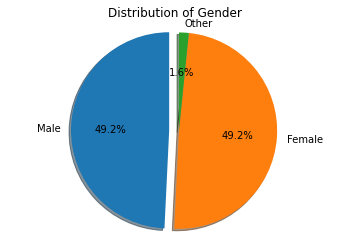

In [53]:
plt_pie_chart(merged_df[(merged_df.offer_type == 'bogo')],'gender','Distribution of Gender')

In [54]:
merged_df.describe()

,time,amount,reward_x,age,income,days_since_membership,reward_y,difficulty,duration,email,mobile,social,web
count,32444.000000,0.0,32444.000000,32444.000000,32444.000000,32444.000000,32444.000000,32444.00000,32444.000000,32444.0,32444.000000,32444.000000,32444.000000
mean,399.615645,NaN,4.948249,55.826624,69430.803847,627.821292,4.948249,9.31411,7.318734,1.0,0.895636,0.646005,0.887283
std,192.577529,NaN,2.905376,16.809418,21604.250324,397.164671,2.905376,4.20840,1.771882,0.0,0.305737,0.478215,0.316252
min,0.000000,NaN,2.000000,18.000000,30000.000000,37.000000,2.000000,5.00000,5.000000,1.0,0.000000,0.000000,0.000000
25%,234.000000,NaN,2.000000,45.000000,53000.000000,308.000000,2.000000,5.00000,7.000000,1.0,1.000000,0.000000,1.000000
50%,432.000000,NaN,5.000000,57.000000,69000.000000,560.000000,5.000000,10.00000,7.000000,1.0,1.000000,1.000000,1.000000
75%,558.000000,NaN,5.000000,67.000000,85000.000000,895.000000,5.000000,10.00000,10.000000,1.0,1.000000,1.000000,1.000000
max,714.000000,NaN,10.000000,101.000000,120000.000000,1860.000000,10.000000,20.00000,10.000000,1.0,1.000000,1.000000,1.000000


Create buckets for age, income and days_since_member

In [55]:
def create_buckets (df):
    '''
    INPUT: the dataframe for which buckets have to be created
    
    OUTPUT: a dataframe with buckets
    '''
    df=df.drop_duplicates()
    df=df.copy()
    ##create buckets for age
    df.loc[(df.age < 20) , 'Age_Group'] = 'Under 20'
    df.loc[(df.age >= 20) & (df.age <= 45) , 'Age_Group'] = '20-45'
    df.loc[(df.age >= 46) & (df.age <= 60) , 'Age_Group'] = '46-60'
    df.loc[(df.age >= 61) , 'Age_Group'] = '>60'
    
    ##create buckets for income
    df.loc[(df.income < 50000) , 'Income_Group'] = 'Under 50k'
    df.loc[(df.income >= 50000) & (df.income <= 70000) , 'Income_Group'] = '50k-70k'
    df.loc[(df.income >= 70001) & (df.income <= 90000) , 'Income_Group'] = '70k-90k'
    df.loc[(df.income >= 90001) , 'Income_Group'] = '>90k'
        
    ##create buckets for days since membership
    df.loc[(df.days_since_membership < 500) , 'Membership_Group'] = 'Under 500'
    df.loc[(df.days_since_membership >= 500) & (df.days_since_membership <= 1000) , 'Membership_Group'] = '501-1000'
    df.loc[(df.days_since_membership >= 1001) & (df.days_since_membership <= 1500) , 'Membership_Group'] = '1001-1500'
    df.loc[(df.days_since_membership >= 1501) , 'Membership_Group'] = '>1501'
    
    ##drop columns
    df.drop('age',axis=1,inplace=True)
    df.drop('income',axis=1,inplace=True)
    df.drop('days_since_membership',axis=1,inplace=True)
    return df

In [56]:
merged_df=create_buckets(merged_df)

In [57]:
merged_df.head()

,person_id,event,time,amount,reward_x,offer_id,gender,reward_y,difficulty,duration,offer_type,email,mobile,social,web,Age_Group,Income_Group,Membership_Group
0,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,5,5,7,bogo,1,1,0,1,>60,>90k,Under 500
1,e2127556f4f64592b11af22de27a7932,offer completed,522,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,5,5,7,bogo,1,1,0,1,>60,50k-70k,Under 500
2,389bc3fa690240e798340f5a15918d5c,offer completed,498,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,5,5,7,bogo,1,1,0,1,>60,50k-70k,Under 500
3,868317b9be554cb18e50bc68484749a2,offer completed,468,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,5,5,7,bogo,1,1,0,1,>60,70k-90k,Under 500
4,f082d80f0aac47a99173ba8ef8fc1909,offer completed,12,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,5,5,7,bogo,1,1,0,1,20-45,Under 50k,501-1000


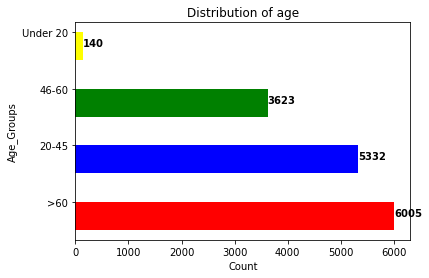

In [58]:
plot_hbar_chart(merged_df[(merged_df.offer_type == 'bogo')],'Age_Group',"Distribution of age","Count","Age_Groups")

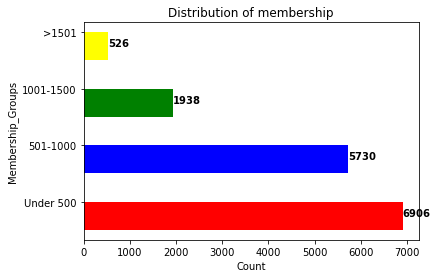

In [59]:
plot_hbar_chart(merged_df[(merged_df.offer_type == 'bogo')],'Membership_Group',"Distribution of membership","Count","Membership_Groups")

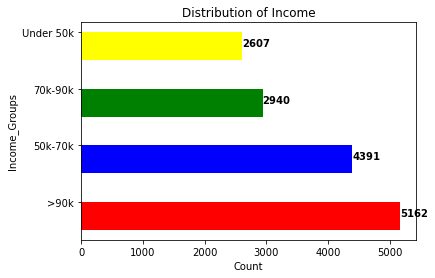

In [60]:
plot_hbar_chart(merged_df[(merged_df.offer_type == 'bogo')],'Income_Group',"Distribution of Income","Count","Income_Groups")

<AxesSubplot:ylabel='Frequency'>

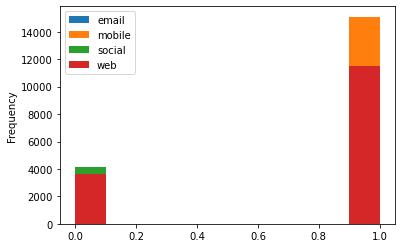

In [61]:
merged_df[(merged_df.offer_type == 'bogo')][["email", "mobile","social","web"]].plot.hist()

Looking at discount offers:

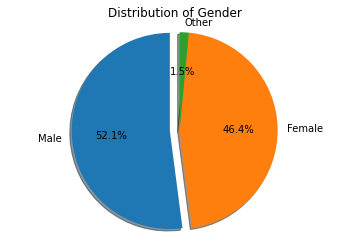

In [62]:
plt_pie_chart(merged_df[(merged_df.offer_type == 'discount')],'gender','Distribution of Gender')

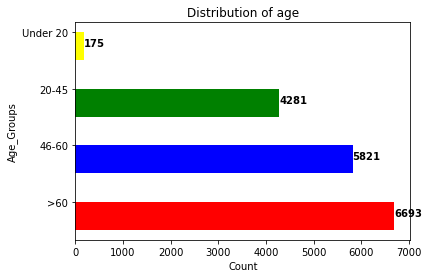

In [63]:
plot_hbar_chart(merged_df[(merged_df.offer_type == 'discount')],'Age_Group',"Distribution of age","Count","Age_Groups")

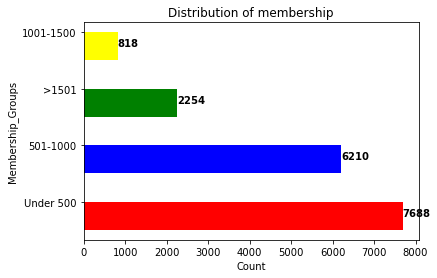

In [64]:
plot_hbar_chart(merged_df[(merged_df.offer_type == 'discount')],'Membership_Group',"Distribution of membership","Count","Membership_Groups")

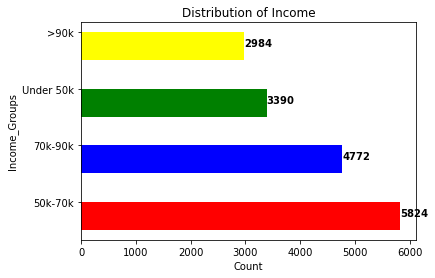

In [65]:
plot_hbar_chart(merged_df[(merged_df.offer_type == 'discount')],'Income_Group',"Distribution of Income","Count","Income_Groups")

<AxesSubplot:ylabel='Frequency'>

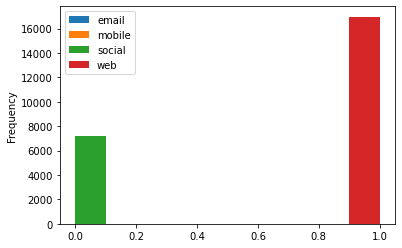

In [66]:
merged_df[(merged_df.offer_type == 'discount')][["email", "mobile","social","web"]].plot.hist()

## Modeling

In [67]:
model_df=pd.merge(profile_clean,merged_df,how='left',on='person_id')

In [68]:
model_df.head()

,gender_x,age,person_id,income,days_since_membership,event,time,amount,reward_x,offer_id,...,difficulty,duration,offer_type,email,mobile,social,web,Age_Group,Income_Group,Membership_Group
0,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,413,offer completed,528.0,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,5.0,7.0,bogo,1.0,1.0,0.0,1.0,46-60,>90k,Under 500
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,480,offer completed,132.0,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,5.0,7.0,bogo,1.0,1.0,0.0,1.0,>60,>90k,Under 500
2,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,480,offer completed,510.0,NaN,10.0,ae264e3637204a6fb9bb56bc8210ddfd,...,10.0,7.0,bogo,1.0,1.0,1.0,0.0,>60,>90k,Under 500
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,480,offer completed,510.0,NaN,5.0,f19421c1d4aa40978ebb69ca19b0e20d,...,5.0,5.0,bogo,1.0,1.0,1.0,1.0,>60,>90k,Under 500
4,M,68,e2127556f4f64592b11af22de27a7932,70000.0,128,offer completed,522.0,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,5.0,7.0,bogo,1.0,1.0,0.0,1.0,>60,50k-70k,Under 500


In [69]:
model_df.isnull().sum()

gender_x                     0
age                          0
person_id                    0
income                       0
days_since_membership        0
event                     2839
time                      2839
amount                   34909
reward_x                  2839
offer_id                  2839
gender_y                  2839
reward_y                  2839
difficulty                2839
duration                  2839
offer_type                2839
email                     2839
mobile                    2839
social                    2839
web                       2839
Age_Group                 2839
Income_Group              2839
Membership_Group          2839
dtype: int64

In [70]:
model_df['event'] = model_df['event'].fillna(0)

In [71]:
model_df["event"].replace({"offer completed": 1}, inplace=True)

As we want to build model on the profile data only, we will drop all other columns that are not required.

In [72]:
model_df=model_df.drop(columns=['person_id', 'time','amount','reward_x','offer_id','gender_y','reward_y','difficulty','duration'
                      ,'offer_type','email','mobile','social','web','Age_Group','Income_Group','Membership_Group'])

In [73]:
model_df=model_df.rename(columns={"gender_x": "gender", "income_x": "income"})

In [74]:
model_df

,gender,age,income,days_since_membership,event
0,F,55,112000.0,413,1
1,F,75,100000.0,480,1
2,F,75,100000.0,480,1
3,F,75,100000.0,480,1
4,M,68,70000.0,128,1
...,...,...,...,...,...
34904,F,83,50000.0,908,1
34905,F,83,50000.0,908,1
34906,F,83,50000.0,908,1
34907,F,62,82000.0,406,1


In [75]:
model_df=create_buckets(model_df)

In [76]:
model_df

,gender,event,Age_Group,Income_Group,Membership_Group
0,F,1,46-60,>90k,Under 500
1,F,1,>60,>90k,Under 500
4,M,1,>60,50k-70k,Under 500
6,M,1,>60,50k-70k,Under 500
11,M,1,46-60,50k-70k,Under 500
...,...,...,...,...,...
34901,F,0,20-45,50k-70k,Under 500
34902,M,1,>60,70k-90k,Under 500
34903,M,0,46-60,70k-90k,501-1000
34904,F,1,>60,50k-70k,501-1000


In [77]:
model_df = pd.get_dummies(model_df, columns = ['gender','Age_Group','Income_Group','Membership_Group'])

In [78]:
model_df

,event,gender_F,gender_M,gender_O,Age_Group_20-45,Age_Group_46-60,Age_Group_>60,Age_Group_Under 20,Income_Group_50k-70k,Income_Group_70k-90k,Income_Group_>90k,Income_Group_Under 50k,Membership_Group_1001-1500,Membership_Group_501-1000,Membership_Group_>1501,Membership_Group_Under 500
0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
1,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
4,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1
6,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1
11,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34901,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1
34902,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1
34903,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0
34904,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0


In [79]:
data=model_df.drop(columns=['event'])

In [80]:
label=model_df['event']

In [81]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size = 0.2, random_state = 0)

print("Training set: {} rows".format(X_train.shape[0]))
print("Testing set: {} rows".format(X_test.shape[0]))

Training set: 11852 rows
Testing set: 2964 rows


In [82]:
from sklearn.metrics import fbeta_score

In [83]:
def train_clf(classifier):
    """
    INPUT: the classifier
    
    OUTPUT: the accuracy on train and test data
    """
    fit=classifier.fit(X_train, y_train)
    y_pred_test=fit.predict(X_test)
    y_pred_train = fit.predict(X_train)
    accuracy_train =  accuracy_score(y_train,y_pred_train)*100
    accuracy_test =  accuracy_score(y_test,y_pred_test)*100
    f1_test= fbeta_score(y_test, y_pred_test,average='macro',  beta=0.5)*100
    f1_train= fbeta_score(y_train, y_pred_train,average='macro',  beta=0.5)*100
    name = classifier.__class__.__name__
    
    return accuracy_train, accuracy_test,f1_test,f1_train, name

We will look at different algorithms and find the accuracy and f1-score of the algorithms. 

## KNN classifier:

In [84]:
classifier0 = KNeighborsClassifier(n_neighbors = 5)
accuracy_train0,accuracy_test0,f1_score_test0,f1_score_train0,classifier_name0 = train_clf(classifier0)

In [85]:
accuracy_train0,accuracy_test0,f1_score_test0,f1_score_train0,classifier_name0

(76.56935538305771,
 76.51821862348179,
 63.14471247390934,
 62.688310723479375,
 'KNeighborsClassifier')

## Random Forest Classifier:

In [86]:
classifier1 = RandomForestClassifier(random_state = 10)
accuracy_train1,accuracy_test1,f1_score_test1,f1_score_train1,classifier_name1 = train_clf(classifier1)

In [87]:
accuracy_train1,accuracy_test1,f1_score_test1,f1_score_train1,classifier_name1

(80.96523793452582,
 80.63427800269906,
 45.130572108165715,
 45.14529818747482,
 'RandomForestClassifier')

## Decision Tree Classifier:

In [88]:
classifier2 = DecisionTreeClassifier(random_state = 10)
accuracy_train2,accuracy_test2,f1_score_test2,f1_score_train2,classifier_name2 = train_clf(classifier2)

In [89]:
accuracy_train2,accuracy_test2,f1_score_test2,f1_score_train2,classifier_name2

(80.96523793452582,
 80.60053981106613,
 45.10506850897832,
 45.14529818747482,
 'DecisionTreeClassifier')

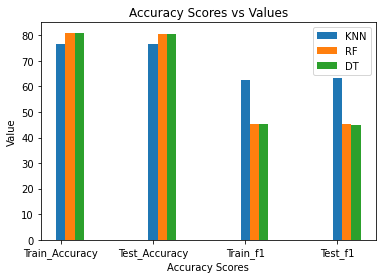

In [104]:
w=0.1
x=['Train_Accuracy','Test_Accuracy','Train_f1','Test_f1']
KNN=[accuracy_train0,accuracy_test0,f1_score_train0,f1_score_test0]
RF=[accuracy_train1,accuracy_test1,f1_score_train1,f1_score_test1]
DT=[accuracy_train2,accuracy_test2,f1_score_train2,f1_score_test2]
bar1=np.arange(len(x))
bar2=[i+w for i in bar1]
bar3=[i+w+w for i in bar1]
  
plt.bar(bar1,KNN,w,label="KNN")
plt.bar(bar2,RF,w,label="RF")
plt.bar(bar3,DT,w,label="DT")
   
plt.xlabel("Accuracy Scores")
plt.ylabel("Value")
plt.title("Accuracy Scores vs Values")
plt.xticks(bar1,x)
plt.legend()
plt.show()

## Hyperparameter tuning

From the above graph we can see that KNN classifier has the highest f1-score so we will be tuning the KNN classifier.

In [105]:
from sklearn.model_selection import GridSearchCV

In [113]:
params = {'n_neighbors':[3,4,5,6,7],
          'algorithm':['auto', 'ball_tree','kd_tree','brute'],
          'leaf_size':[1,2,5],
          }

In [114]:
model1 = GridSearchCV(classifier0, param_grid=params)

In [115]:
model1.fit(X_train,y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [1, 2, 5],
                         'n_neighbors': [3, 4, 5, 6, 7]})

In [116]:
print("Best Hyper Parameters:\n",model1.best_params_)

Best Hyper Parameters:
 {'algorithm': 'auto', 'leaf_size': 2, 'n_neighbors': 5}


In [117]:
predict=model1.predict(X_test)

In [122]:
f1_test_param= fbeta_score(y_test, predict,average='micro',  beta=0.5)*100

In [123]:
f1_test_param

77.32793522267207

# Conclusion

From the analysis above we can see that the f1-score of the KNN classifier increased from 63% to 77%. The model can be further tuned by considering other parameters and using GridSearchCV to find the list of best parameters to improve the model further.